# Implementing DCA in pytorch

Source CC function in [seqmodel](https://github.com/sokrypton/seqmodels/blob/master/seqmodels.ipynb)
Reimplemeting tensorflow code in pytorch

In [1]:
import numpy as np
import torch

import read_config
from dataloader import MSADataset, OneHotTransform

In [2]:
config = read_config.Config("../config2d.yaml")
dataset = MSADataset(config.aligned_msa_fullpath, transform=OneHotTransform(21, flatten=False))

N = len(dataset)

protein_seq, weight = dataset[0]
ncat = 21
L = protein_seq.shape[0]
ncol = L

N, L

(14441, 559)

In [3]:
protein_seq.shape

torch.Size([559, 21])

In [4]:
ncol, ncat

(559, 21)

In [5]:
# L2 regularization
lam_w = 0.1
lam_b = 0.1



In [6]:
batch_size = config.batch_size
#batch_size = len(dataset) ## to load in the whole dataset
msa = torch.utils.data.DataLoader(dataset, batch_size)

for _, msa_data in enumerate(msa):
    data  = msa_data[0]
    seq_weights = msa_data[1]
    break
    
print(f"Data.shape = {data.shape}")
print(f"Weights.shape = {seq_weights.shape}")

Data.shape = torch.Size([128, 559, 21])
Weights.shape = torch.Size([128])


In [7]:
device = config.device

In [8]:
bias = torch.zeros((ncol,ncat), dtype=torch.float, requires_grad=True, device=device)
w = torch.zeros((ncol, ncat, ncol, ncat), dtype=torch.float, requires_grad=True, device=device)

num_epochs = config.epochs
#num_epochs = 10

# Tell the optimizer which weights we want to update
optimizer = torch.optim.SGD([bias, w], lr=config.learning_rate)
ce_loss_func = torch.nn.CrossEntropyLoss(reduction='none')

In [9]:
data = data.to(device)
seq_weights = seq_weights.to(device)

# This is the number of effective sequences if the batch size is the full dataset
sum_seq_weights = torch.sum(seq_weights)

Epoch=00, Loss=1701.89
Epoch=01, Loss=1318.83
Epoch=02, Loss=1049.85
Epoch=03, Loss=903.73
Epoch=04, Loss=833.69
Epoch=05, Loss=797.48
Epoch=06, Loss=776.24
Epoch=07, Loss=762.37
Epoch=08, Loss=752.52
Epoch=09, Loss=745.06
Epoch=10, Loss=739.16
Epoch=11, Loss=734.33
Epoch=12, Loss=730.29
Epoch=13, Loss=726.85
Epoch=14, Loss=723.87
Epoch=15, Loss=721.28
Epoch=16, Loss=719.02
Epoch=17, Loss=717.02
Epoch=18, Loss=715.25
Epoch=19, Loss=713.68
Epoch=20, Loss=712.29
Epoch=21, Loss=711.04
Epoch=22, Loss=709.92
Epoch=23, Loss=708.92
Epoch=24, Loss=708.02
Epoch=25, Loss=707.22
Epoch=26, Loss=706.49
Epoch=27, Loss=705.83
Epoch=28, Loss=705.24
Epoch=29, Loss=704.70
Epoch=30, Loss=704.21
Epoch=31, Loss=703.77
Epoch=32, Loss=703.37
Epoch=33, Loss=703.00
Epoch=34, Loss=702.67
Epoch=35, Loss=702.37
Epoch=36, Loss=702.10
Epoch=37, Loss=701.85
Epoch=38, Loss=701.62
Epoch=39, Loss=701.41
Epoch=40, Loss=701.22
Epoch=41, Loss=701.04
Epoch=42, Loss=700.88
Epoch=43, Loss=700.73
Epoch=44, Loss=700.60
Epoch=4

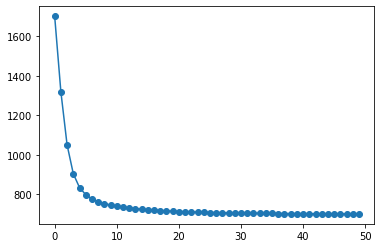

In [10]:
losses = []
for epoch in range(num_epochs):
    
    # we do not want weights between the various nodes in a given position. 
    # i.e. weights between nodes (i, a) and (j, b) only exist if i not = j
    # so set these weights to zero
    w_eye = w * torch.reshape(1 - torch.eye(ncol), (ncol,1,ncol, 1))
    # symmetrize w so that the weight between (i,a) and (j, b) is the
    # same as the weight between (j, b) and (i, a)
    weights = w_eye + w_eye.permute(2,3,0,1)
    
    data_logit = torch.tensordot(data, weights, 2) + bias

    # pytorch cross entropy is different from tensorflow categorical cross entropy
    # 1. It takes in the logits by default and does its own softmax activation
    # 2. It wants the class lables in the target (LongTensor instead of Float)
    loss_ce = ce_loss_func(data_logit.permute(0,2,1), data.argmax(dim=2))
    loss_ce_sum = loss_ce.sum(dim=-1)
    unreg_loss = (loss_ce_sum * seq_weights).sum()

    reg_w = lam_w * torch.sum(torch.mul(weights, weights)) * 0.5 * (ncol-1) * 20.0 
    reg_b = lam_b * torch.sum(torch.mul(bias, bias))
    reg = reg_w + reg_b
    
    loss = (unreg_loss + reg) / sum_seq_weights
    losses.append(loss.item())
    print(f"Epoch={epoch:02d}, Loss={losses[-1]:6.2f}")
    loss.backward()

    optimizer.step()
    optimizer.zero_grad()

import matplotlib.pyplot as plt
plt.plot(losses, "o-");